# P3: Clearing OpenStreetMap Data

## _ by Lieby Cardoso _ 
                                                
* Region selected for the project:

I selected Belo Horizonte, MG, Brazil because it is the city where I live and I believe it is interesting to know some local points, also the domain of previous information about the region can assist in the analysis of the information registered.
Region: http://www.openstreetmap.org/relation/368782 

### Content

1. Methods and tools
2. Problems found on the map
3. Data overview
4. Other Ideas About the Data
5. Conclusion
6. References


### 1.	Methods and tools

Descriptive of the methods and tools used in this work 
https://github.com/liebycardoso/OpenStreetMap/blob/master/Methods.pdf 

### 2. Problems found on the map

** Location identification of street type **

Unlike the exercises performed, where the map was from the city of Chicago and the street type could be identified by theLast name, on the map of Belo Horizonte, the name of the street consists of the type, abbreviated or not, followed by the name. To meet this particularity of the Brazilian nomenclature, the variable street_type_re has been reformulated to work with the first word of the sentence. The change consisted in including the ^ character, which always corresponds to The start of the string and deletion of the $ character, which corresponds to the end of the string.

Code snippet:

In [ ]:
 street_type_re = re.compile(r'^\b(?u)\w\S+\.?', re.IGNORECASE)

** Special Characters **

When starting auditing the data, I printed on the screen the name of some streets of the sample and the logic of the program was not followed in some cases because streets with special characters such as acute accents ('), circumflexes (^), til (~) And cedilla (ç). 

In the header of the script the command # - coding: utf-8 - was included to allow manipulation of these characters with the utf-8 Unicode encoding.

Even doing this inclusion, it was necessary to add the letter 'u' before strings that were used for comparison. An example is the word "Square" manually included as a comparative string of the expected variable, when comparison of "Square" typed with Square returning from a variable, the comparison was not successful in this case the word "Square" entered was replaced by u"Square" to be recognized as containing special character. 

Another treatment was to include the encoding (? U) \ w for all Unicode characters in re.compile.

Code snippet: 

In [22]:
# -*- coding: utf-8 -*-
expected_street = ["Rua", "Avenida", "Beco", "Rodovia", "Expressa", u"Praça", "Anel", "Alameda"]

** Ways  without type defined and type mapping**

Some roads did not have their defined type, for example, avenue, “alameda”, alleyway and etc ... When the road did not have the type compatible with those registered in the expected array, nor in the mapping_street dictionary, I assigned the prefix "Street" to all of them.

- Method: update_street_type (name, mapping):
- Script: audit_map_bh

Roads without type:
- Montes Claros => Rua Montes Claros
- Paracatu => Rua Paracatu
- Francisco Deslandes => Rua Francisco Deslandes
- Riachuelo => Rua Riachuelo

Roads with mapped type:
- Av São Lucas => Avenida São Lucas
- Anél Rodoviário => Anel Rodoviário
- Avendia Dom Pedro II => Avenida Dom Pedro II
- Alamedas das Princesas => Alameda Das Princesas
- Eua Conceição Aparecida => Rua Conceição Aparecida
- Pc Nossa Senhora do Rosário => Praça Nossa Senhora Do Rosário
- R. A => Rua A
- R.B => Rua B

** Short titles **

After correcting the abbreviation for the name of the streets, I noticed that some streets were under the title of the person who gave the name Street abbreviated. In BH all cases were Prof. In the place of Professor.

- Method: update_street_title (name, mapping):
- Script: audit_map_bh

Example:

- Prof. Melchíades da Costa Lage Street => Professor Melchíades Da Costa Lage Street

** Name of the city **

The map of the Belo Horizonte region also contains information about the metropolitan region, for this reason the key Addr: city received a treatment to standardize the names, since, were spelled errors and the name of the city composed with the name of the state.

- Method: update_city (name, mapping):
- Script: audit_map_bh

Example:

- Belo Horizon => Belo Horizonte
- Belo Horizonte - MG => Belo Horizonte
- Belo Horizonte MG Brazil => Belo Horizonte

** Postal Code **

The postal code is an important attribute of the address and the count of values, I realized that there was a good volume of Data, I standardized the field as a sequence of 8 numbers without the character "-".

- Method: update_code_postal (name, mapping):
- Script: audit_map_bh

## 3. Data overview

###  Representation of OSM data 

The data is organized into a structure of map elements that represent the object and its associated value.
Types found:

- Node: a node is information of a pair of coordinates, being latitude and longitude;
- Way: a list of nodes;

Although OpenStreetMap has two more types of elements listed below, they were not considered in this project.

- Area: represents a limited area, for example, a square;
- Relation: can be a set of related nodes, ways and relation.

###  Import data for search

The mapbh.json file, generated after analyzing the OSM data for Belo Horizonte, was imported into MongoDB through the command line:

* => mongoimport -h 127.0.0.1:27017 --db openstreetmap --collection mapbh --file C:/Nanodegree/MongoDb/Trab_final/mapbh.json  


The data in MongoDB will be accessed and manipulated through the pymongo library. 

In [2]:
import pprint
import matplotlib.pyplot as plt
%matplotlib inline
import pymongo
from bson import SON
from pymongo import MongoClient
client=MongoClient('localhost:27017')
db=client.openstreetmap

The imported data is part of a collection named mapbh (--collection mapbh). Verifying that the name was created correctly:

In [29]:
db.collection_names()

[u'mapbh']

###  Knowing the data

** 3.1. Statistics of data **

A summary of total documents and data size.

In [19]:
stats_mapbh = db.command("dbstats")

In [29]:
print "Tamanho da colecao: ", stats_mapbh["dataSize"]
print "Total de documentos: ",  stats_mapbh["objects"]
print "Total de indices: " , stats_mapbh["indexes"]

Tamanho da colecao:  112706375.0
Total de documentos:  466927
Total de indices:  1


** 3.2. Number of documents with type "node": **

In [38]:
db.mapbh.find({"type":"node"}).count() 

408052

** 3.3. Number of documents with type "way": **

In [39]:
db.mapbh.find({"type":"way"}).count()

58875

** 3.4. Documents with different type of "way" and "node": **

The total of node and way is (408,052 + 58,875) 466,927, slightly different from the 466,990 listed in db.mapbh.find (). Count (). I will list those records that are not way, nor node to identify the problem, since in the shape_element function I read the records by tags that contain the "node" and "way" strings.

In [70]:
list(db.mapbh.find({"type":{"$nin":["way","node"]}}))

[]

By traversing the above records it is possible to notice that they have a "type" tag, since no method that filtered this type of situation, the value of this tag itself replaced that of the "type" tag that should have the type of attribute tag.

These records that have been compromised by the programming logic will be deleted from the collection. One correction possible in the shape_element function is to assign the value of node ['type'] = element.tag to the end process and not at the beginning, as it was implemented.

In [47]:
db.mapbh.delete_many({"type":{"$nin":["way","node"]}})

Is it now that all records are of type node or way? Let's check if the total of documents in the collection is equal to total records with way + node.

In [50]:
db.mapbh.find().count() == db.mapbh.find({"type":{"$in":["way","node"]}}).count()

True

The comparison returned True and the records were deleted correctly.

** 3.5. Size of OSM and JSON files **

- mapbh.OSM => 93.432 kb
- mapbh.json => 136.726 kb
- mapbh collection => 112.706 kb

** 3.6. Contributing users with OSH from BH **

Total unique users who contributed to the BH map:

In [4]:
print "Total de usuários: " , len(db.mapbh.distinct("created.uid"))

Total de usuários:  593


Name and total contributions of the user who most contributed to the BH OSM:

In [32]:
pipeline=[
            {"$match": {"type": "node"}},
            {"$group": {"_id": {"Cod":"$created.uid", "user":"$created.user"}, "total": {"$sum": 1}}},
            {"$sort" : {"total" : -1}},
            {"$limit": 1}
          ]

list(db.mapbh.aggregate(pipeline))

[{u'_id': {u'Cod': u'397143', u'user': u'Vitor Dias'}, u'total': 128024}]

Total of other users' contributions:

In [9]:
pipeline=[
            {"$match": {"type": "node", "created.uid" :{"$ne": "397143"}}},
            {"$group": {"_id": "TotalContibuicoesUsuarios", "total": {"$sum": 1}}},
            {"$sort" : {"total" : -1}}
          ]

list(db.mapbh.aggregate(pipeline))

[{u'_id': u'TotalContibuicoesUsuarios', u'total': 280028}]

The user Vitor Dias is responsible for 32% of the contribution of the data.

## 4. Other Ideas About the Data

** The world capital of the botecos ... is it ?! **

Belo Horizonte is proud to be the world capital of the botecos. If you've been here before, probably even if you know a few cities, you must have realized that this is true. Can we see this information in the data?

In [39]:
pipeline = [{"$match": {"amenity":{"$ne": None,"$exists": 1}}},
            {"$group":{"_id":"$amenity" , "total":{"$sum":1}}},
            {"$sort" : {"total" : -1}},
            {"$limit": 10}            
           ]
            
list(db.mapbh.aggregate(pipeline))

[{u'_id': u'Restaurant', u'total': 443},
 {u'_id': u'School', u'total': 394},
 {u'_id': u'Parking', u'total': 261},
 {u'_id': u'Fuel', u'total': 260},
 {u'_id': u'Bank', u'total': 210},
 {u'_id': u'Place_Of_Worship', u'total': 208},
 {u'_id': u'Pub', u'total': 154},
 {u'_id': u'Bar', u'total': 148},
 {u'_id': u'Pharmacy', u'total': 130},
 {u'_id': u'Fast_Food', u'total': 126}]

No surprise, Restaurant, Pub and Bar appear in the top 10. We have more Pubs and Bars than pharmacies!

We already know that restaurant is the most common type of installation, now we will see the type of cuisine that each one offers:

In [41]:
pipeline = [
            {"$match":{"cuisine":{"$exists":1}, "amenity":{"$exists":1}, "amenity":"Restaurant"}},
            {"$group": {"_id":"$cuisine", "total": {"$sum":1}}},
            {"$sort" : {"total" : -1}},
            {"$limit": 5}]

list(db.mapbh.aggregate(pipeline))

[{u'_id': u'Regional', u'total': 59},
 {u'_id': u'Pizza', u'total': 30},
 {u'_id': u'Italian', u'total': 20},
 {u'_id': u'Japanese', u'total': 8},
 {u'_id': u'Fish', u'total': 7}]

The result is quite reasonable, the region has several restaurants of Minas Gerais food (Regional) and pizzerias that is common in most cities.

** Finding places through your geographic point **

This section is not intended to provide a real search tool for latitude and longitude points, the purpose of which is to only display an optional form of search in the data, since we are analyzing a map and the information of location is available.
The first thing to do is to create a new mirror field of the "pos" field in all the documents in the collection in which it exist. To do this, I update the field using the $ set command, since the field does not exist, MongoDB will do its creation. At this time the field will only receive the string pos.

In [81]:
db.mapbh.update_many({"pos":{"$ne": None,"$exists": 1}},
                    {"$set": {"loc": "pos"}})

After creating the field, I'll turn it into a geospatial type index, for this is just to report pymongo.GEO2D.

In [66]:
db.mapbh.create_index([("loc", pymongo.GEO2D)])

u'loc_2d'

In this third step I will search all the records that have the field pos filled and store in the variable pos. The objective is to use this variable as a source of information in the feed of loc values, which at the moment is the string pos as a single value.

In [106]:
pos = list(db.mapbh.find({"pos":{"$exists":1}}))

Finally, I go through all registers of the variable pos and for each one I enter the value of latitude and longitude where _id is the same.

In [108]:
for item in pos:
    db.mapbh.update_one({"_id": item["_id"]},
                        {"$set": {"loc": item["pos"]}})   

Now that the index is created, I'll search for a coordinate in a well-known BH street. That information will be passed on as a reference point in the survey of nearby places.

In [64]:
list(db.mapbh.find({"address.street" : "Avenida Do Contorno"}))[0]

{u'_id': ObjectId('58641665ed425d6e306c706e'),
 u'address': {u'housenumber': u'5771',
  u'postcode': u'30110-035',
  u'street': u'Avenida Do Contorno'},
 u'amenity': u'Pub',
 u'created': {u'changeset': u'21700331',
  u'timestamp': u'2014-04-15T00:45:03Z',
  u'uid': u'2032426',
  u'user': u'Victor Caldeira Colen',
  u'version': u'6'},
 u'id': u'320934190',
 u'loc': [-19.9398678, -43.9312457],
 u'name': u'Stadt Jever',
 u'pos': [-19.9398678, -43.9312457],
 u'source': u'Web',
 u'type': u'node',
 u'website': u'Http://Wals.Com.Br/Stadt-Jever'}

 I'm going to search places near the coordinate [-19.93, -43.94]. You can use the "MinDistance" to restrict the distance from the points you are looking for.

In [65]:
%time db.mapbh.find({'loc': SON([('$near', [-19.93, -43.93]), ('$maxDistance', 0.001)])}).count()

Wall time: 3 ms


24

In [ ]:
mapa = folium.Map(location=posicao_mapa[0]["loc"], zoom_start=18,
                   tiles='Stamen Terrain')
for item in posicao_mapa:
    folium.Marker(item["loc"], popup=item["id"]).add_to(mapa)
mapa.save('pontosbh.html')

<img src="pontos_localizados.jpg">

We found 24 results for this search, not bad! And the search time is very fast, only 2ms to go through the collection with 408 thousand documents.

#### Cities

The City Name attribute was audited in the previous phase and its values were mapped. Let's run a query that returns the name of the cities and total of streets registered for each one of them.

In [43]:
pipeline = [{"$unwind" : "$address.city"},
            {"$group": {"_id" : {"cidade":"$address.city", "rua":"$address.street"}, "ccount": {"$sum": 1}}},
            {"$group" : {"_id": "$_id.cidade", "TotalRuas" : {"$sum": "$ccount"}}},
            {"$sort" : {"TotalRuas" : -1}}
            ]

total_rua_cidades = list(db.mapbh.aggregate(pipeline))

In [44]:
pprint.pprint(total_rua_cidades)

[{u'TotalRuas': 328, u'_id': u'Belo Horizonte'},
 {u'TotalRuas': 16, u'_id': u'Betim'},
 {u'TotalRuas': 12, u'_id': u'Contagem'},
 {u'TotalRuas': 8, u'_id': u'Nova Lima'},
 {u'TotalRuas': 5, u'_id': u'Sarzedo'},
 {u'TotalRuas': 5, u'_id': u'Sabar\xe1'},
 {u'TotalRuas': 4, u'_id': u'Santa Luzia'},
 {u'TotalRuas': 2, u'_id': u'Ribeir\xe3o Das Neves'}]


In the list of cities the name Belo Horizonte appears twice being one of them with incorrect spelling "Belo Horizont". To correct the situation in the database I updated the name to the correct one. This failure occurred because in the Update_city of the audit_map_BH script I assigned to Belo Horizonte a size of [0:13], when it should have been [0:14]. The method has been fixed and updated.

In [26]:
db.mapbh.find({"address.city":"Belo Horizont"}).count()

8

In [28]:
db.mapbh.update({"address.city":"Belo Horizont"}, 
                {"$set": {"address.city":"Belo Horizonte"}},multi=True)

C:\Program Files (x86)\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  from ipykernel import kernelapp as app


{u'n': 8, u'nModified': 8, u'ok': 1, 'updatedExisting': True}

Now that the data is consistent, let's print a pie chart with the distribution of streets registered by city. There are data registered for the capital Belo Horizonte and for cities in the metropolitan region.

([<matplotlib.patches.Wedge at 0xc517128>,
  <matplotlib.text.Text at 0xc5d2240>])

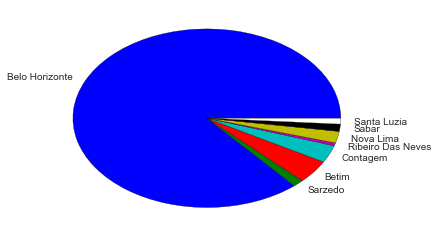

In [30]:
cidade = []
total = []
for item in total_rua_cidades:
    total.append(item["TotalRuas"])
    cidade.append(item["_id"].encode('ascii', 'ignore'))
plt.pie(x=total,labels=cidade)

### Improvement in data

The lack of registered data for the points of interest makes it difficult to use OpenStreetMap. In a search that I did at http://www.openstreetmap.org/(http://www.openstreetmap.org/) for places near my address,  I wasn’t able to locate the establishments I know. I did the registration of a supermarket and a veterinarian, and It would be interesting if this insertion of data could be done through an app that would stimulate the registration of information while you are in that location, just as the Waze application does, added to this a recognition with medals for frequent contributors, style games like Pokemon Go =). 

Governamental agencies like Minas Gerais's tourism Ministry could encourage hotel chains to register their establishment and about the interesting points that a guest could use during the stay. This would strengthen the map and visitation in the region.

## 5. Conclusion

A significant part of the data from Belo Horizonte is not formatted according to my expectation, which difficulted to obtain results with more volume of information, this absence of the attributes of some streets makes this project without statistical value and prevents it from being a reflection of the characteristics of Belo Horizonte. 

The count of streets with the address.street attribute registered, returned only 320 results to Belo Horizonte, demonstrating the lack of completion of some records for the 6th most populous city in Brazil.

Despite this obstacle, the map met the objective of the analysis and enabled a good learning of the manipulation of data using pymongo and MongoDB.


## 6. Referências

- wiki.openstreetmap.org/wiki/Belo_Horizonte
- wiki.openstreetmap.org/wiki/WikiProject_Brazil
- overpass-api.de/api/map?bbox=-44.3092,-20.0979,-43.6116,-19.7376
- github.com/FrankRuns/Udacity/tree/master/OpenStreetMap-Analysis/OSM_Data_Project
- github.com/ucaiado/OpenStreetMaps
- pt.slideshare.net/mbright1/using-mongodb-and-python-demo